# Image Alignment
**Satya Mallick, LearnOpenCV.com**

## Align an image to a template.
![alt text](image-alignment-using-opencv.jpg "Image Alignment")

## Theory

1. A **Homography** transforms a square to arbitrary quad. 

![alt text](motion-models.jpg "Motion Models")






## Theory
2. Images of two planes are related by a **Homography**
3. We need **4 corresponding points** to estimate Homography


!["Homography Example"](homography-example.jpg)|

In [22]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Read Tempalate and Scanned Image

In [23]:
# Read reference image
refFilename = "form.jpg"
print("Reading reference image : ", refFilename)
im1 = cv2.imread(refFilename, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# Read image to be aligned
imFilename = "scanned-form.jpg"
print("Reading image to align : ", imFilename)
im2 = cv2.imread(imFilename, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
  

Reading reference image :  form.jpg
Reading image to align :  scanned-form.jpg


Text(0.5, 1.0, 'Scanned Form')

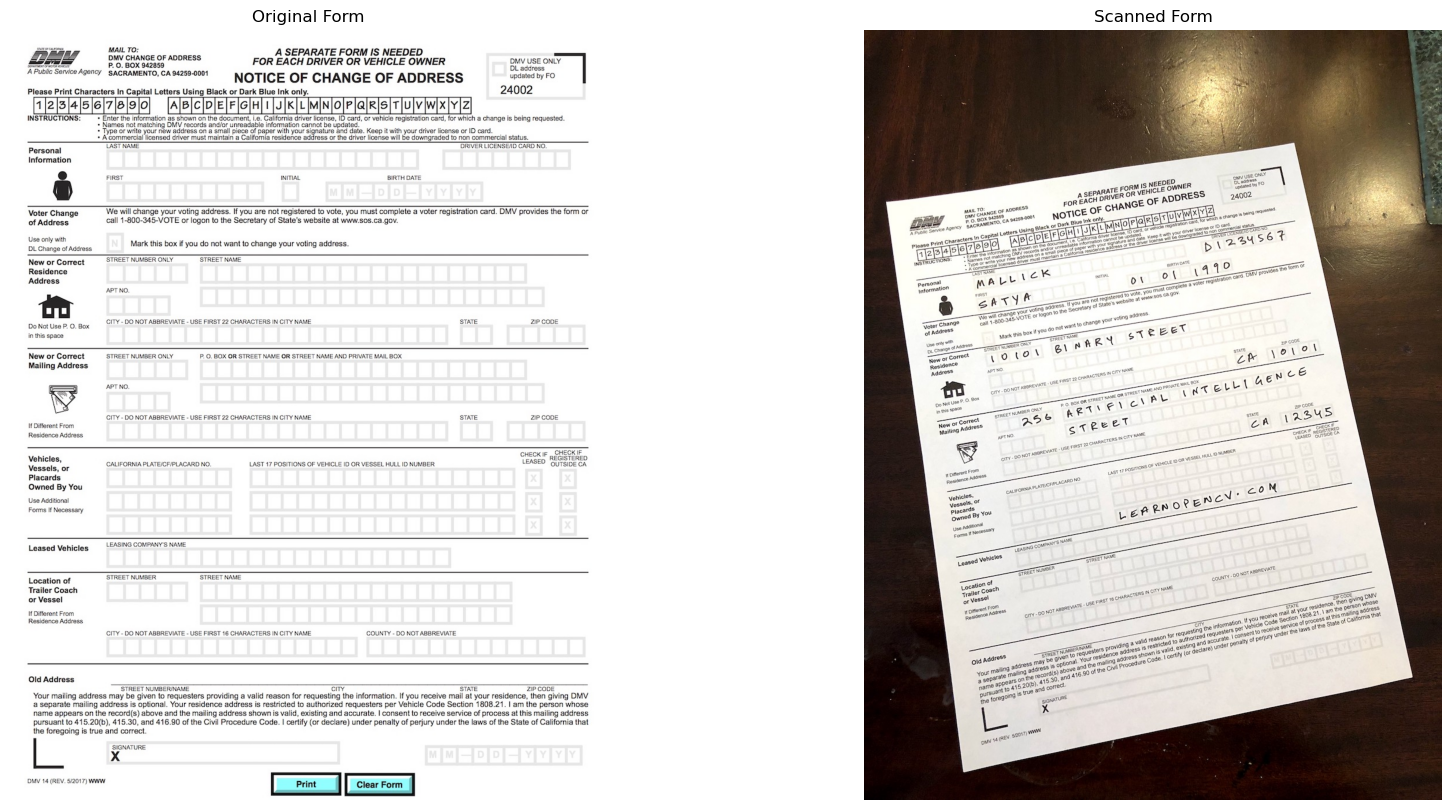

In [24]:
# Display Images

plt.figure(figsize=[20,10]); 
plt.subplot(121); plt.axis('off'); plt.imshow(im1); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(im2); plt.title("Scanned Form")

## Personal Notes - Step 1

Image Alignment

img => Operation => Final Img



## Step 2: Find keypoints in both Images

Think of keypoints as corner points that are stable under image transformations

In [25]:
# Convert images to grayscale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
# create ORB object
orb = cv2.ORB_create(MAX_NUM_FEATURES)
# extract keypoints and descriptors from grayscales imgs
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

# Display 
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]), color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


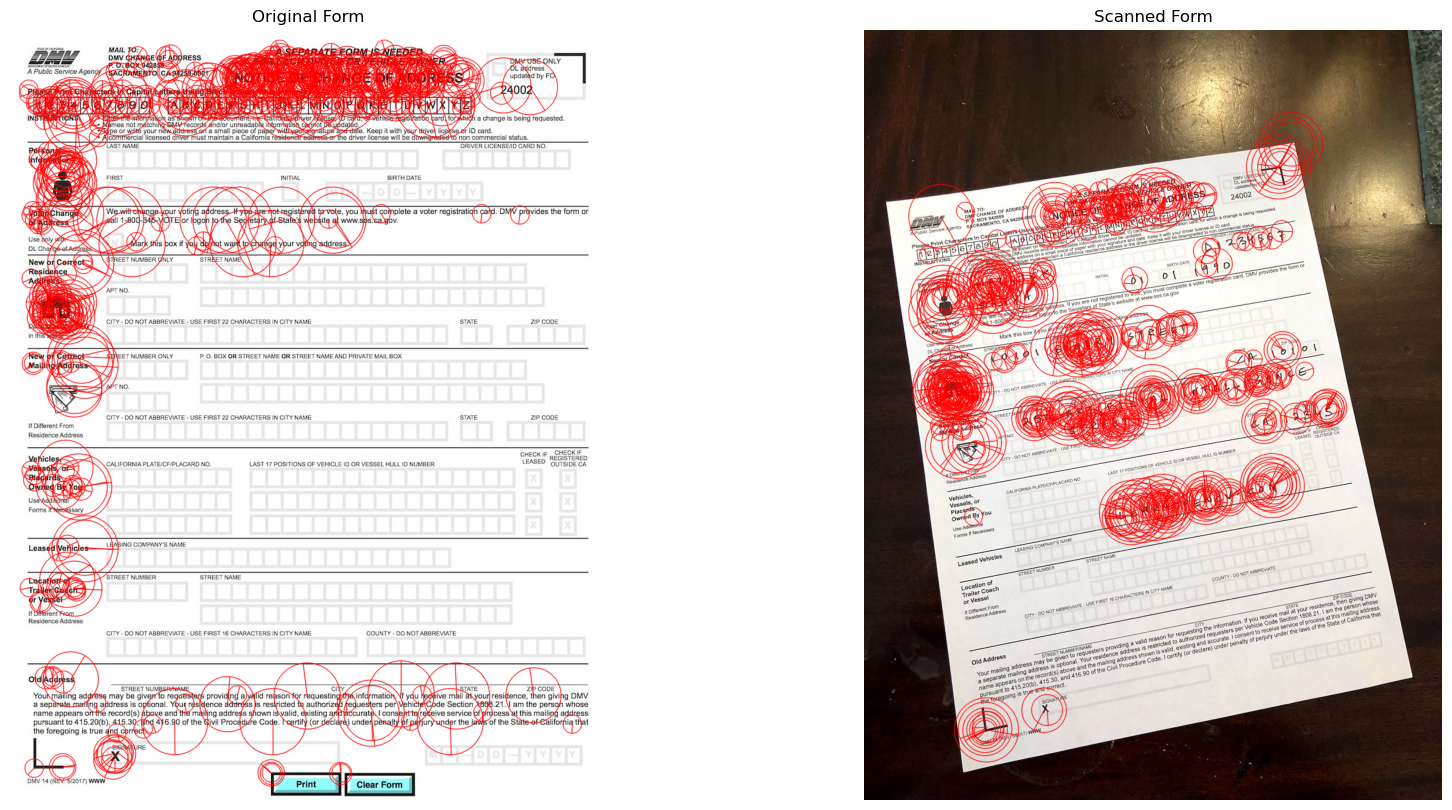

In [26]:
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title("Original Form");
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title("Scanned Form");

## Personal Notes Step 2:

### Features Extraction

Features: points of interest in an img, defined by its pixel coord[u,v]

- Feature types
    - Edges
    - Corners/interest points
    - Blobs/region of interest points
    - Ridges 

**Visual Feature pipeline:** 
`Detection => Description => Matching`

We use `descriptor` to extract feature keypoints from the image
- Keypoints: feature types described by pixels coord(u,v)
- Descriptor: image summary: [f1...fN], where f: img feature [u,v]

Descriptor types based on the type of features: 
- SIFT, SURF, GLOH, BRIEF, ORB (Oriented Fast and Rotated Brief) ...

- We later use the descriptor to match up the keypoints of two image
- Finally apply the homagraphy

## Step 3 : Match keypoints in the two image

In [27]:
# Match features.
# create matcher obj
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors1, descriptors2, None)

# print(f'matches:{matches}, matches type:{type(matches)}')
# convert matches tuples to list to avoid the following errors:
# AttributeError: 'tuple' object has no attribute 'sort'
matches = [x for x in matches]

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]


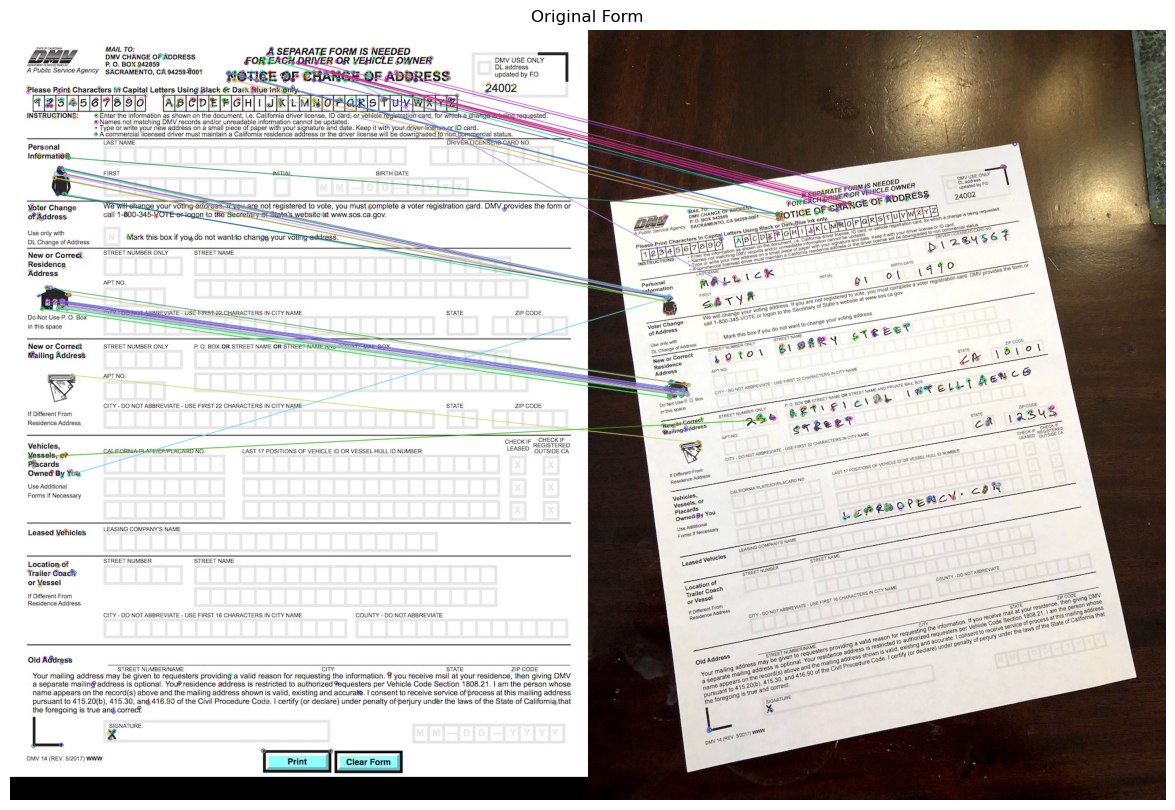

In [28]:
# Draw top matches
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=[40,10])
plt.imshow(im_matches); plt.axis('off'); plt.title("Original Form");


## Step 4:  Find Homography



In [29]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
  points1[i, :] = keypoints1[match.queryIdx].pt
  points2[i, :] = keypoints2[match.trainIdx].pt
  
# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

## Step 5: Warp image

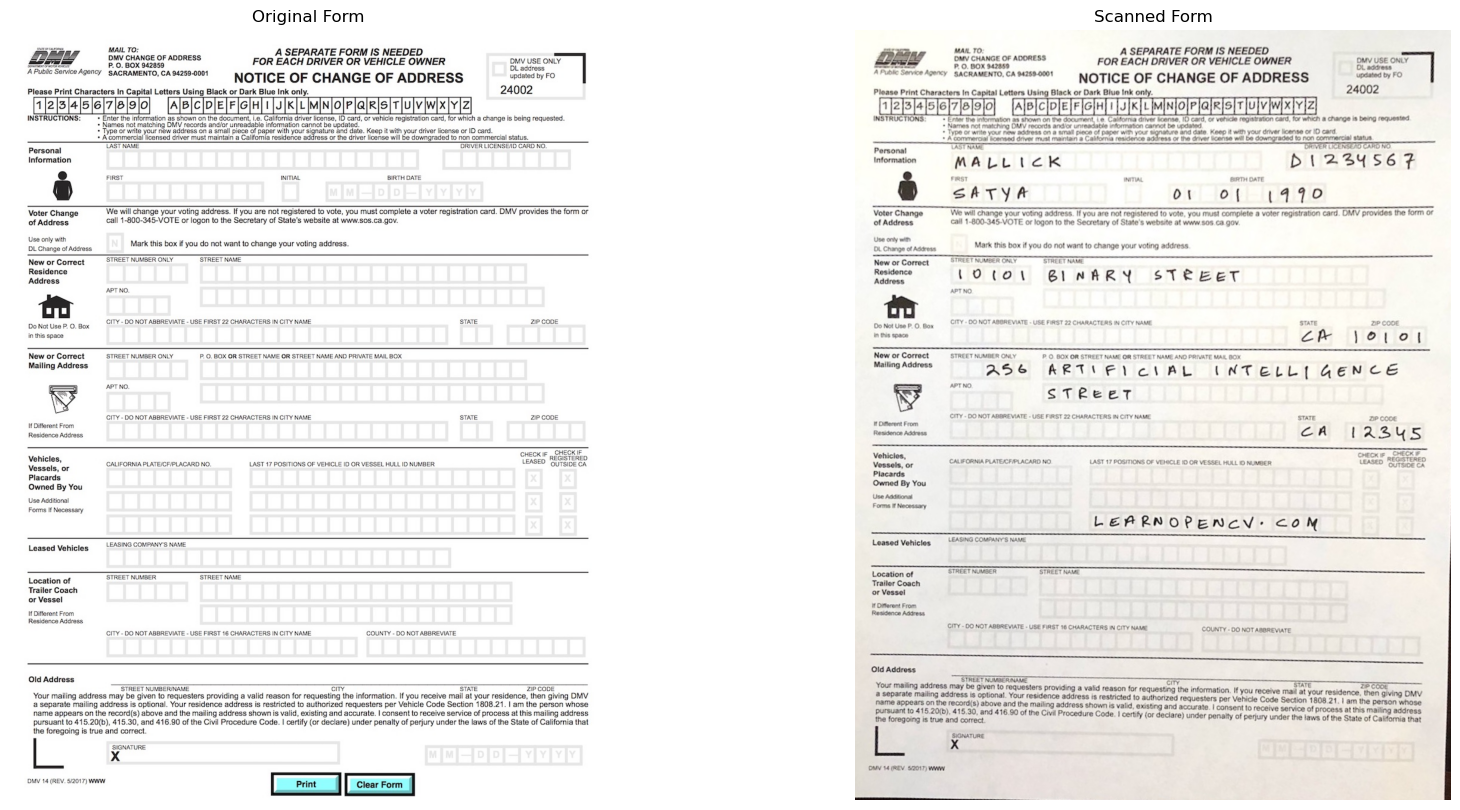

In [30]:
# Use homography to warp image
height, width, channels = im1.shape
im2_reg = cv2.warpPerspective(im2, h, (width, height))
# Display results 
plt.figure(figsize=[20,10]); 
plt.subplot(121); plt.imshow(im1); plt.axis('off'); plt.title("Original Form");
plt.subplot(122); plt.imshow(im2_reg); plt.axis('off'); plt.title("Scanned Form");